In [1]:
# So that the interpreter can access scripts.
import os
import sys

path_project = os.path.abspath(os.path.join(os.getcwd(), ".."))
if path_project not in set(sys.path):
    sys.path.append(path_project) # To avoid insert it many times

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scripts.dbscan import DBSCAN_Analysis
from scripts.kmeans import centroid_clusters, plot_kmeans_stats, kmeans_statistics 
import seaborn as sns
from time import time_ns

# <span style = "color:brown"><ins>ANALYSIS OF CLIENT'S BEHAVIOUR OF A E-COMMERCE RETAIL</ins></span>

The datasets that we will use for this exploratory analysis are the following:

## USERS DATASET

### Variables:

* id: User's identifier
* country: Where the user belongs.

[Investopedia (2024, August 14) What is Frequency, Recency, Monetary value (RFM) in Marketing?](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp)

The RFM is a marketing tool used for a firm to identify which are the best clients or customers according by their spending habits. Through this model, an organization is able to score them (1 to 5) by using these variables. And in this way, they can predict which ones are likely to purchase their products again or how to turn occasional buyers into habitual ones.

RFM analysis allows a comparison between potential contributors and clients. It gives organizations a sense of how much revenue comes from repeat customers (vs new customers).

* R: Recency. How long ago the user made a purchase.
* F: User's purchase frequency. How often they make purchases.
* M: Monetary value that the customer spends on purchases.


In [5]:
# TRANSFORMATION OF THE RAW DATA:
df_users = pd.read_csv("../data/users.csv", index_col="id")

In [6]:
df_users.dtypes

country      int64
R            int64
F            int64
M          float64
dtype: object

Let's see which countries's id are the most frequent in the users of this retail.

In [7]:
n = df_users.shape[0]
# Plot the proportion of users by country's id
prop = df_users["country"].value_counts() / n
prop[:5]

country
25    0.982086
46    0.002750
13    0.002041
39    0.001553
20    0.001458
Name: count, dtype: float64

We can see that the $98$% of the users belongs to the country whose identifier is 25. Unfortunately, we don't have a table that tell us which country is according to the id.

On the other hand, it's interessant to take a look of the last time that users has made a purchase in the e-commerce retail. We will consider the values of `R` is expresseed in days according to its description for this task.

count    557006.000000
mean         63.370895
std         128.671249
min           0.000000
25%           5.000000
50%          18.000000
75%          58.000000
max        1095.000000
Name: R, dtype: float64

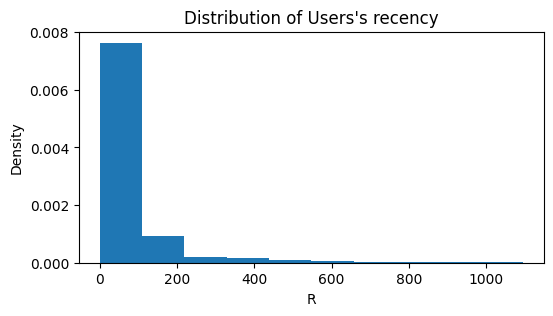

In [8]:
df_users['R'].plot(kind = "hist",
                   title = "Distribution of Users's recency",
                   density = True,
                   ylabel = "Density",
                   xlabel = "R",
                   figsize = (6, 3)
                  )
df_users['R'].describe()

In [9]:
R_pct = lambda threshold: np.mean(df_users["R"] <= threshold).round(2) * 100
R_outcome = lambda days: print(f"The {R_pct(days)}% of users has made a purchase in the last {days//30} month(s) aprox.")
# Compute how long ago the vast majority of users has made a purchase
R_outcome(200)
# The pct of people that made a purchase in the last month
R_outcome(30)
# Customers who have not made a purchase in over year
R_geq_365 = 100 - R_pct(365)
print(f"The {R_geq_365}% of users have not made a purchase in over a year.")

The 93.0% of users has made a purchase in the last 6 month(s) aprox.
The 62.0% of users has made a purchase in the last 1 month(s) aprox.
The 4.0% of users have not made a purchase in over a year.


This variable has a high variability. We can see that more than 50% of records in this sample is from people that has made a purchase in the last month. The organization needs to pay attention of them, because the more recently a user has made a purchase with a company, the more likely they will continue to keep the business and brand in mind for subsequent purchases.

Now, let's know about how often the clients make a purchase by studying the variable `F`.

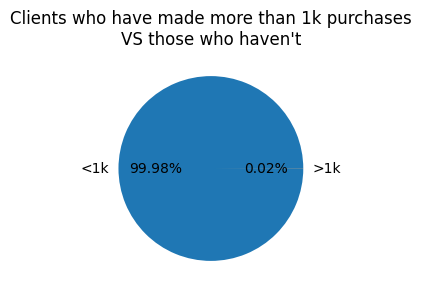

count    557006.000000
mean         36.941340
std          57.409948
min           0.000000
25%           8.000000
50%          22.000000
75%          47.000000
max       10754.000000
Name: F, dtype: float64

In [10]:
F_intervals = pd.cut(df_users['F'], 
                     [0, 1000, df_users['F'].max()], 
                     labels = ["<1k", ">1k"],
                     include_lowest=True)
# Graph
fig, ax = plt.subplots(figsize = (4, 3))
ax.pie(F_intervals.value_counts(),
        autopct = "%.2f%%",
        labels = F_intervals.unique())
ax.set_title("Clients who have made more than 1k purchases\nVS those who haven't")
plt.show()
# Stats
df_users['F'].describe()

It's amazing that there are customers that have made more than 1k purchases, let's see when it was the last time that they have made a purchase in order to see if this happened in the last month.

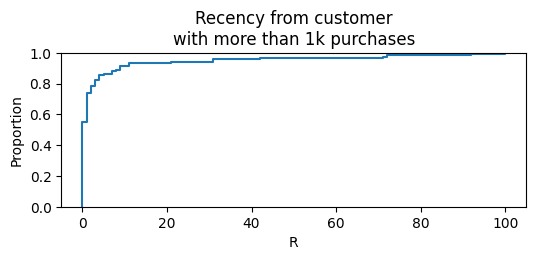

In [11]:
F_geq_1k = df_users["F"] >= 10**3
# Graph
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_title("Recency from customer\nwith more than 1k purchases")
sns.ecdfplot(df_users.loc[F_geq_1k, :], x="R", ax = ax)
plt.show()

As we have expected, more than 80% of these customers have made a purchase in at most 20 days ago. They could be the group of loyal customers for this organization due to the combination of their recency (`R`) and frequency (`F`).

It's time to visualize the amount of money that the customers have spent in this period. We want to know if those who have make a large number of purchases are the ones who have spent more money.

count    5.570060e+05
mean     3.980345e+02
std      3.781268e+04
min      0.000000e+00
25%      2.758333e+01
50%      3.794000e+01
75%      5.179052e+01
max      1.516590e+07
Name: M, dtype: float64

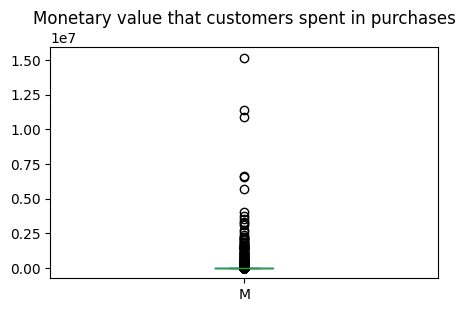

In [12]:
df_users["M"].plot(kind = "box", 
                  figsize = (5, 3),
                  title = "Monetary value that customers spent in purchases")
df_users["M"].describe()

In [13]:
M_leq_1c = np.mean(df_users["M"] <= 100) * 100
print(f"The {M_leq_1c: .2f}% of customer have spent at most 100 dollars in purchases")

The  96.85% of customer have spent at most 100 dollars in purchases


There is people who have spent millions of dollars in purchases! Let's check if they are those who have made a purchase in the last month and have a large number of purchases. 

,R,F,M
count,48.000000,48.000000,4.800000e+01
mean,384.958333,2.625000,2.856458e+06
std,290.338171,2.393475,2.863818e+06
min,1.000000,1.000000,1.029800e+06
25%,160.500000,1.000000,1.398750e+06
50%,318.000000,1.000000,1.822938e+06
75%,518.250000,4.000000,2.802600e+06
max,1080.000000,10.000000,1.516590e+07


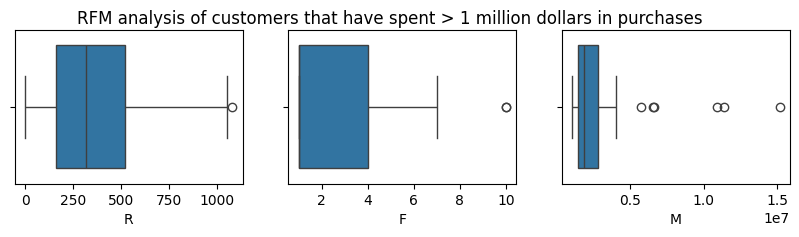

In [14]:
M_geq_1M = df_users.loc[df_users["M"] >= 1e6, ["R", "F", "M"]] 
# Graph
fig, axes = plt.subplots(1, 3, figsize = (10, 2))
fig.suptitle("RFM analysis of customers that have spent > 1 million dollars in purchases")
for idx, stat in enumerate(M_geq_1M.columns):
    sns.boxplot(M_geq_1M[stat], ax=axes[idx], orient = "h")
# Stats
M_geq_1M.describe()

It's interesting that despite the fact these customers are those who spent the largest amount of money in this e-commerce retail, there is a high variability in `R`, where the 50% of people have not made a purchase for more than 10 months (>300 days) ago approx. Also, they are not frequent customers, because the 50% of customers have only buy 1 stuff, but its cost is millionaire.


In [15]:
pct_revenue = np.round(M_geq_1M.loc[:, "M"].sum() / df_users.loc[:, "M"].sum(), 2) * 100
print(f"Although these customers are not the active buyers, their contribution represent the {pct_revenue: .2f}% of revenues for this organization.")

Although these customers are not the active buyers, their contribution represent the  62.00% of revenues for this organization.


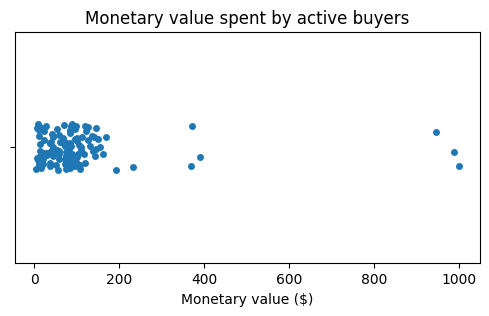

In [16]:
M_active_buyers = df_users.loc[F_geq_1k, :]
# Graph
fig, ax = plt.subplots(figsize = (6, 3))
ax.set_title("Monetary value spent by active buyers")
ax.set_xlabel("Monetary value ($)")
sns.stripplot(M_active_buyers, x = "M", ax=ax)
plt.show()

The active buyers are also the ones who purchase the cheapest things. Because they have made more than 1k purchases and the vast majority of these observations has only spent at most 200$ dollars.

Through these results one could think that there is no a relation between `F` and `M`. Because, if a customer spend a lot of money, that does not mean that this is a active buyer in the e-commererce retail, and vicerversa. Even though, a possible relation could exist between the frequency and recency, after analyzing the group of customers that have made more than 1k purchases. Let's see the correlation matrix:

KeyboardInterrupt: 

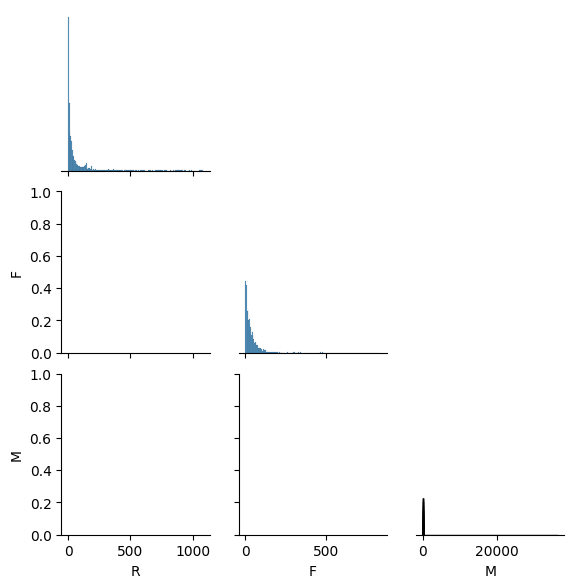

In [17]:
# It's necessary to choose a sampple from our dataset due to its size 
np.random.seed(123)

start = time_ns()

# Graph
(
    sns.pairplot(
        data= df_users.loc[
            np.random.choice(range(1, n + 1), size = 5000, replace = False),
            ['R', 'F', 'M']],
        corner=True,
        height=2)
)
plt.plot()

end = time_ns() - start
print(f"This taks tooks {end * pow(10, -9): .2f} seconds")

You can see through the scatterplot between `F` and `M` that there is no a correlation. People who makes a lot of purchases are not the ones that more money spent. Also, as we have said, the people who have peformed millionaire purchases have the lowest `F` values.  

On the other hand, despite the fact that there is no clear correlation between `F` and `R`, most customers who made their last purchase recently are the ones more purchases have made.

It would be interesting to use the $k$-means algorithm in order to create clusters of customers and analyze what kind of attributes are significant in each of them. To choose the correct value of $k$, we will to analyze the following statistics:

* Within Cluster Sums of Squares or Inertia: To measure how compact the clusters are. $$\text{WSS} = \Sigma_{i = i}^{N_c}\Sigma_{x \in C_i}\|x - \bar{X}_{C_i}\|^2$$

* Between Cluster Sums of Squares: To measure how well-separated the clusters are. $$\text{BSS} = \Sigma_{i = 1}^{N_c} |C_i|\cdot\|\bar{x}_{C_i} - \bar{X}\|^2$$

Where: $$N_c\rightarrow\text{Number of clusters};\quad|C_i|\rightarrow\text{Number of elements of ith cluster};\quad\bar{X}_{C_i}\rightarrow\text{Centroid of ith cluster};\quad\bar{X}\rightarrow\text{Overall centroid}$$

In [ ]:
# This task is computanionally intensive. So we decide to store the results, to avoid
# executing this cell many times:

data_path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
files = set(os.listdir(data_path))
# Training data
np.random.seed(123)
sample = np.random.choice(range(1, n + 1),
                          size = round(n*0.2),
                          replace = False)
X_train = df_users.loc[sample, ["R", "F", "M"]]
if "kmeans.csv" not in files:
    # Set training data
    start = time_ns()
    
    WSS, BSS = kmeans_statistics(X_train)
    kmeans_data = pd.DataFrame({"WSS": WSS, "BSS": BSS})
    kmeans_data.to_csv("../data/kmeans.csv")

    end = (time_ns() - start) * pow(10, -9)
    print(f"This task tooks {end: .2f} seconds")
else:
    print("The results have been stored in ../data/")

Let's apply the elbow method to find out the $k$ that increases the BSS and decreases the WSS significantly.

In [ ]:
# Load the results of k-means:
df_kmeans = pd.read_csv("../data/kmeans.csv")
df_kmeans.drop("Unnamed: 0", axis = 1, inplace=True)
df_kmeans["K"] = range(2, df_kmeans.shape[0] + 2)
# Graph
plot_kmeans_stats(df_kmeans)

You can see that there is a $k$ between 0 and 10 (approx.), where both WSS and BSS converge. Let's take a closer look at this.

In [ ]:
plot_kmeans_stats(df_kmeans.iloc[:10, :])

The elbow is at $k = 4$. And we have only considered the 20% of observations for the training data. So, let's check which features are characterized for these 4 clusters obtained.

In [ ]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(X_train)
# Get centroids
centroid_clusters(model, X_train.columns)

As we saw earlier, only a small group of individuals ($\approx <5\%$) have spent millions of dollars in purchases, despite the fact that they are not frequent customers. On the other hand, since the $\approx 97\%$ of people have spent at most as 100 dollars in purchases, then it is normal that when sampling, the vast majority of data points will come from this group.

Although the $K$-means algorithm by using the elbow method suggest to take $k=4$. We could consider that there are two groups that are defined in the following way:
* Cluster 1: People who could be considered frequent shoppers. Well, on average, they have purchased more than 35 products and their most recent purchase was in the last 3 months.
* Cluster 2: There are characteristics that people who have spent millions of dollars on purchases have in common. On average, they have only purchased less than 5 products and their last purchases was more than 10 months ago.

---

## PRODUCTS DATASET

It contains the information about the products that digital retail offers:

### Variables:
* Discount: Indicate if the product is on sale (eg. 1 or 0).
* Embedding: A lower dimensional representation of the product flat's image from computer vision techniques.
* Partnumber: Product ID.
* Color ID: Product color identifier.
* Code section: Section to which the product belongs.
* Family: Product family to which the product belongs. 

In [ ]:
with open("../data/products.pkl", "rb") as df:
    df_products = pickle.load(df)

We have the embeddings of the products's images, which are multidimentional vectors that capture the main visual features of each product. So, by using this variable, we can assess the similarity between products, analyzing their shapes, textures and other characteristics. 

So, the goal is to group those products with similar features by using the DBSCAN algorithm (Ester et.all, 1996) and compare this result by using the $k$-means algorithm. Also, we could suspect about the number of clusters by using the `Family` or `Code section` variables.

In [4]:
df_products.loc[:, ["cod_section", "family"]].describe().loc[["min", "max"], :]

,cod_section,family
min,1.0,1.0
max,4.0,217.0


In [5]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43692 entries, 0 to 43691
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   discount     43692 non-null  object 
 1   embedding    37522 non-null  object 
 2   partnumber   43692 non-null  int32  
 3   color_id     43692 non-null  int32  
 4   cod_section  43602 non-null  float64
 5   family       43692 non-null  int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 1.5+ MB


There is a problem with the column `embedding`, since there are null values into it. So, we have to discard them to apply the ML algorithms.

In [6]:
# Load embeddings
data_files = os.listdir(os.path.abspath(os.path.join(os.getcwd(), "../data")))
if "embeddings.csv" not in data_files:
    embeddings = df_products.loc[df_products.embedding.apply(lambda x: x is not None), "embedding"]
    df_embeddings = []
    for record in embeddings:
        df_embeddings.append(record)
    pd.DataFrame(df_embeddings).to_csv("../data/embeddings.csv")
else:
    print("embeddings.csv already exists")
    df_embeddings = pd.read_csv("../data/embeddings.csv", )

embeddings.csv already exists


In [7]:
# Set a random sample
np.random.seed(987)
n = df_embeddings.shape[0]
products_sample = df_embeddings.iloc[np.random.choice(n + 1, round(n * 0.2)), :]

The main goal is to specify when a region is considered dense. Therefore, we need to set the following parameters:

* `eps`: Maximum distance between two points to be considered neighbors.
* `min_samples`: Minimum number of neighbors around a point $p$ to be considered a core point and to form a dense region. Then, if $q$ is a neighbor of $p$, it satisfies that $d(p, q) \leq \text{eps}$. The expression to define the set of neighbors of a point $p$ with a distance `eps` is $N_{\text{eps}}(p)$. There is no strict rule for setting this hyperparameter, but we can start with 4 because of the `cod_section`. 

Another important term is noise, where a point $q$ is considered noise or sparse, if $N_{\text{eps}} < \text{min. samples}$. An helpful tool for finding out possible sparse point is by using the $k$ Nearest Neighbors algorithm. You can set an specific $k$, get the $k$-distance of each point, discard the null values and plot these values in ascending order. Finally, you have to check at which point the elbow appears, like we have done in the $k$-means algorithm when analyzing the `USERS` dataset. And, why is this done? Because, it's the inflection point where the average distance between a point and its neighbots increases significantly, so it can be considered a potential sparse point.

* Stats table:
  - [x] Min_samples
  - [x] Elbow or eps
  - [ ] % de ruido
  - [ ] Numero de clusters
  - [ ] Silouette

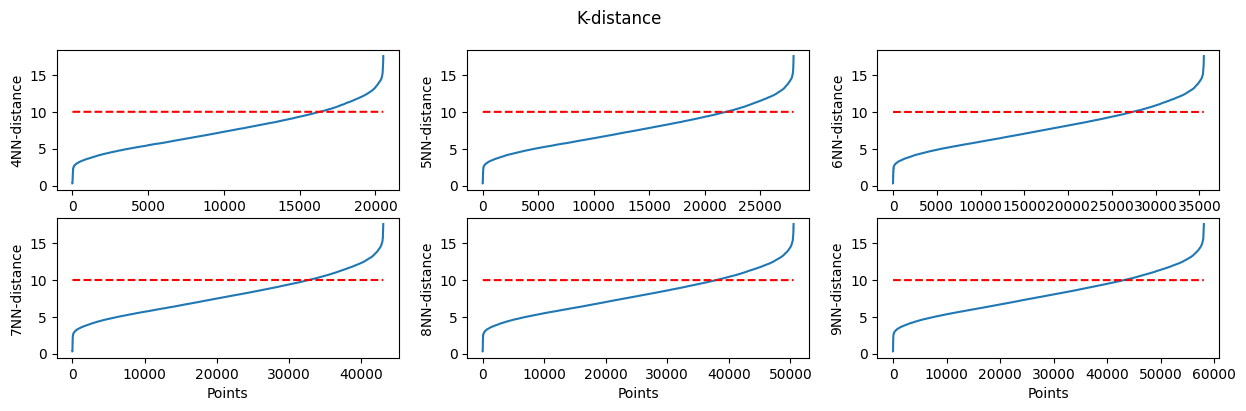

In [9]:
dbscan = DBSCAN_Analysis(sample=products_sample, k_min=4)
dbscan.suitable_eps_search(elbow=10)